# FIR和IIR滤波器

在介绍滤波器之前，先介绍一下几个采样相关的概念：

* 采样频率：每秒钟采样多少个点，需大于奈奎斯特频率，符号 $f_s$
* 采样宽度：量化目标的位数，音频处理中一般为16位（pyaudio中用几个byte表示）
* 频率分辨率：DFT转换时每个频点间的频率差值，等于采样频率除以参数DFT运算的个数N，即 $f_s / N$


DFT特性：

* 输出相位是奇对称的，输出幅度是偶对称的（对于实数序列来说）
* 输入序列移位，对应频率相移
* 输入是偶函数，则输出相位为0
* 输入是奇函数，则输出振幅为0
* DFT频率相位是相对与该频率点余弦波的相位
* 当输入含有的频率不是DFT频率分辨率倍数时，将发生频谱泄漏
* 对输入序列补零以增加DFT点数，则频域数据插值（没有提高频率分辨率）
* 采样率不变时，增加输入序列的DFT点数，则提高频率分辨率
* 矩形窗的基频等于采样率除以矩形窗的点数（即 $f_s / N_w$）,画图时主瓣和旁瓣个数之和为 $N_w - 1$

DFT频率幅度响应公式(sinc函数)：

$$
X(m) = \frac{A_0 N}{2} \frac{sin(\pi * (k - m))}{\pi * (k - m)}
$$

其中 $A_0$ 时振幅，N 是DFT点数, k 是实际频率对应频率分辨率的倍数，为整数时泄漏为0，非整数时有泄漏。

FIR滤波器公式为：

$$
y(m) = \sum_{i=0}^N b_i * x(m-i)
$$

IIR 滤波器公式为：

$$
y(m) = \sum_{i=0}^N b_i * x(m-i) - \sum_{i=1}^M a_i * y(m-i)
$$

经验分享：

* 时域相乘频域卷积（时域乘以正弦信号后相当于频域移动 --- 调频）

本文使用 [signal.lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) 滤波器函数。


下面代码显示一段均值滤波器的处理数据的相关效果。

<IPython.core.display.Javascript object>


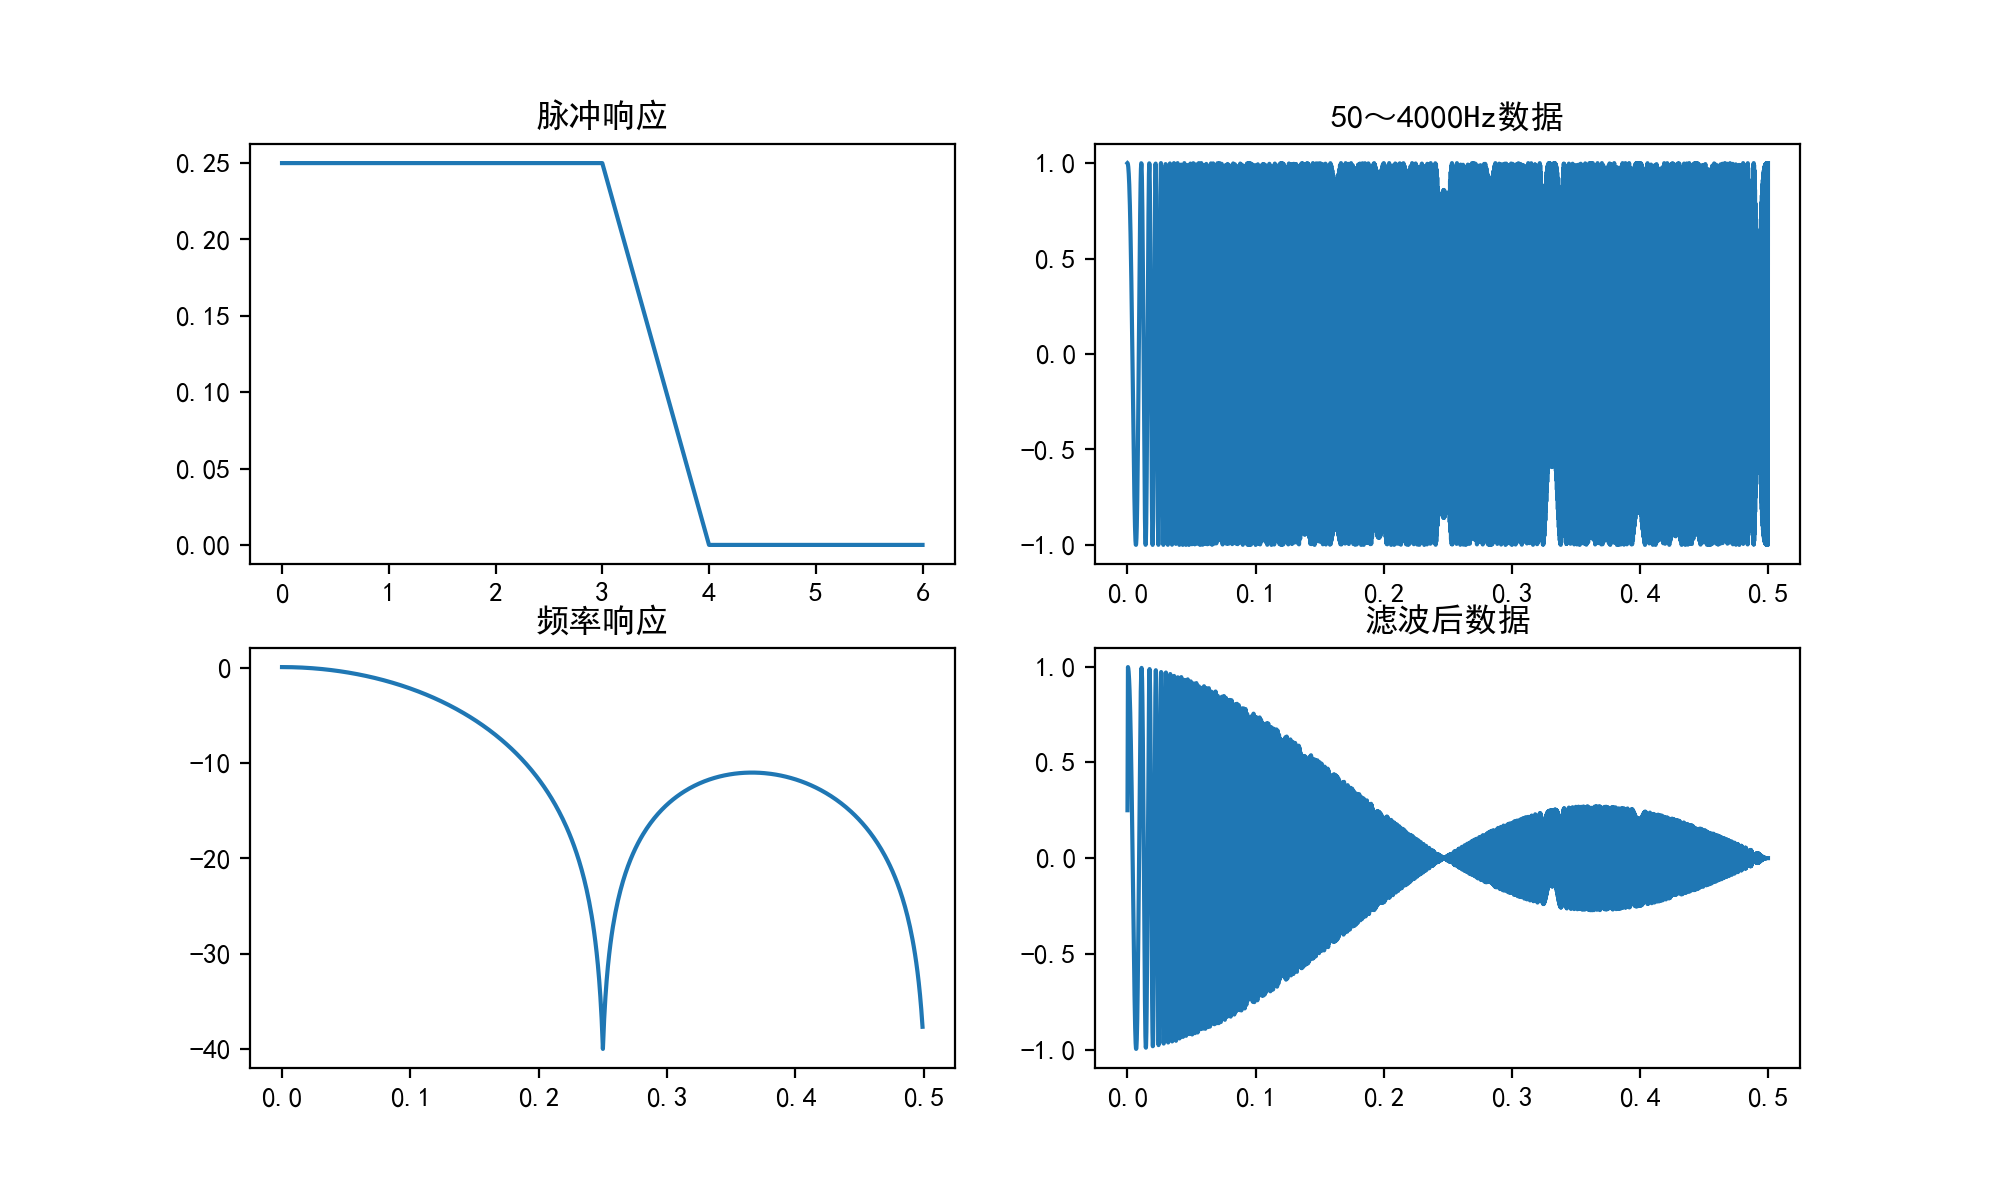

In [21]:
%matplotlib notebook
import wave
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

sample_rate = 8000
time = 0.5

# 均值滤波器系统 FIR
b = np.array([0.25, 0.25, 0.25, 0.25])
a = np.array([1.0])

# 生成 0.5s 的音频数据，采样率 8k，频率从 50 ~ 4000
t = np.arange(0, time, 1.0/sample_rate)
x = signal.chirp(t, 50, time, 4000)

# 滤波器处理
y = signal.lfilter(b, a, x, zi=None)


# 计算滤波器的脉冲响应
impulse = np.zeros(7)
impulse[0] = 1
imp_y = signal.lfilter(b, a, impulse)

# 计算频率响应
w, h = signal.freqz(b,a)

# 画图
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.title('脉冲响应')
plt.plot(imp_y)

plt.subplot(2,2,2)
plt.title('50～4000Hz数据')
plt.plot(t, x)

plt.subplot(2,2,3)
plt.title('频率响应')
plt.plot(w/2/np.pi, 20*np.log10(np.abs(h)+0.01))

plt.subplot(2,2,4)
plt.title('滤波后数据')
plt.plot(t, y)

plt.show()

# 低通滤波器

滤波器系统可以通过手动计算或者使用现成的函数来生成：

* signal.firwin : 生成低通滤波器的 FIR 系数
* signal.remez : 生成带通滤波器的 FIR 系数

滤波器采样点跟频率的关系：

<IPython.core.display.Javascript object>


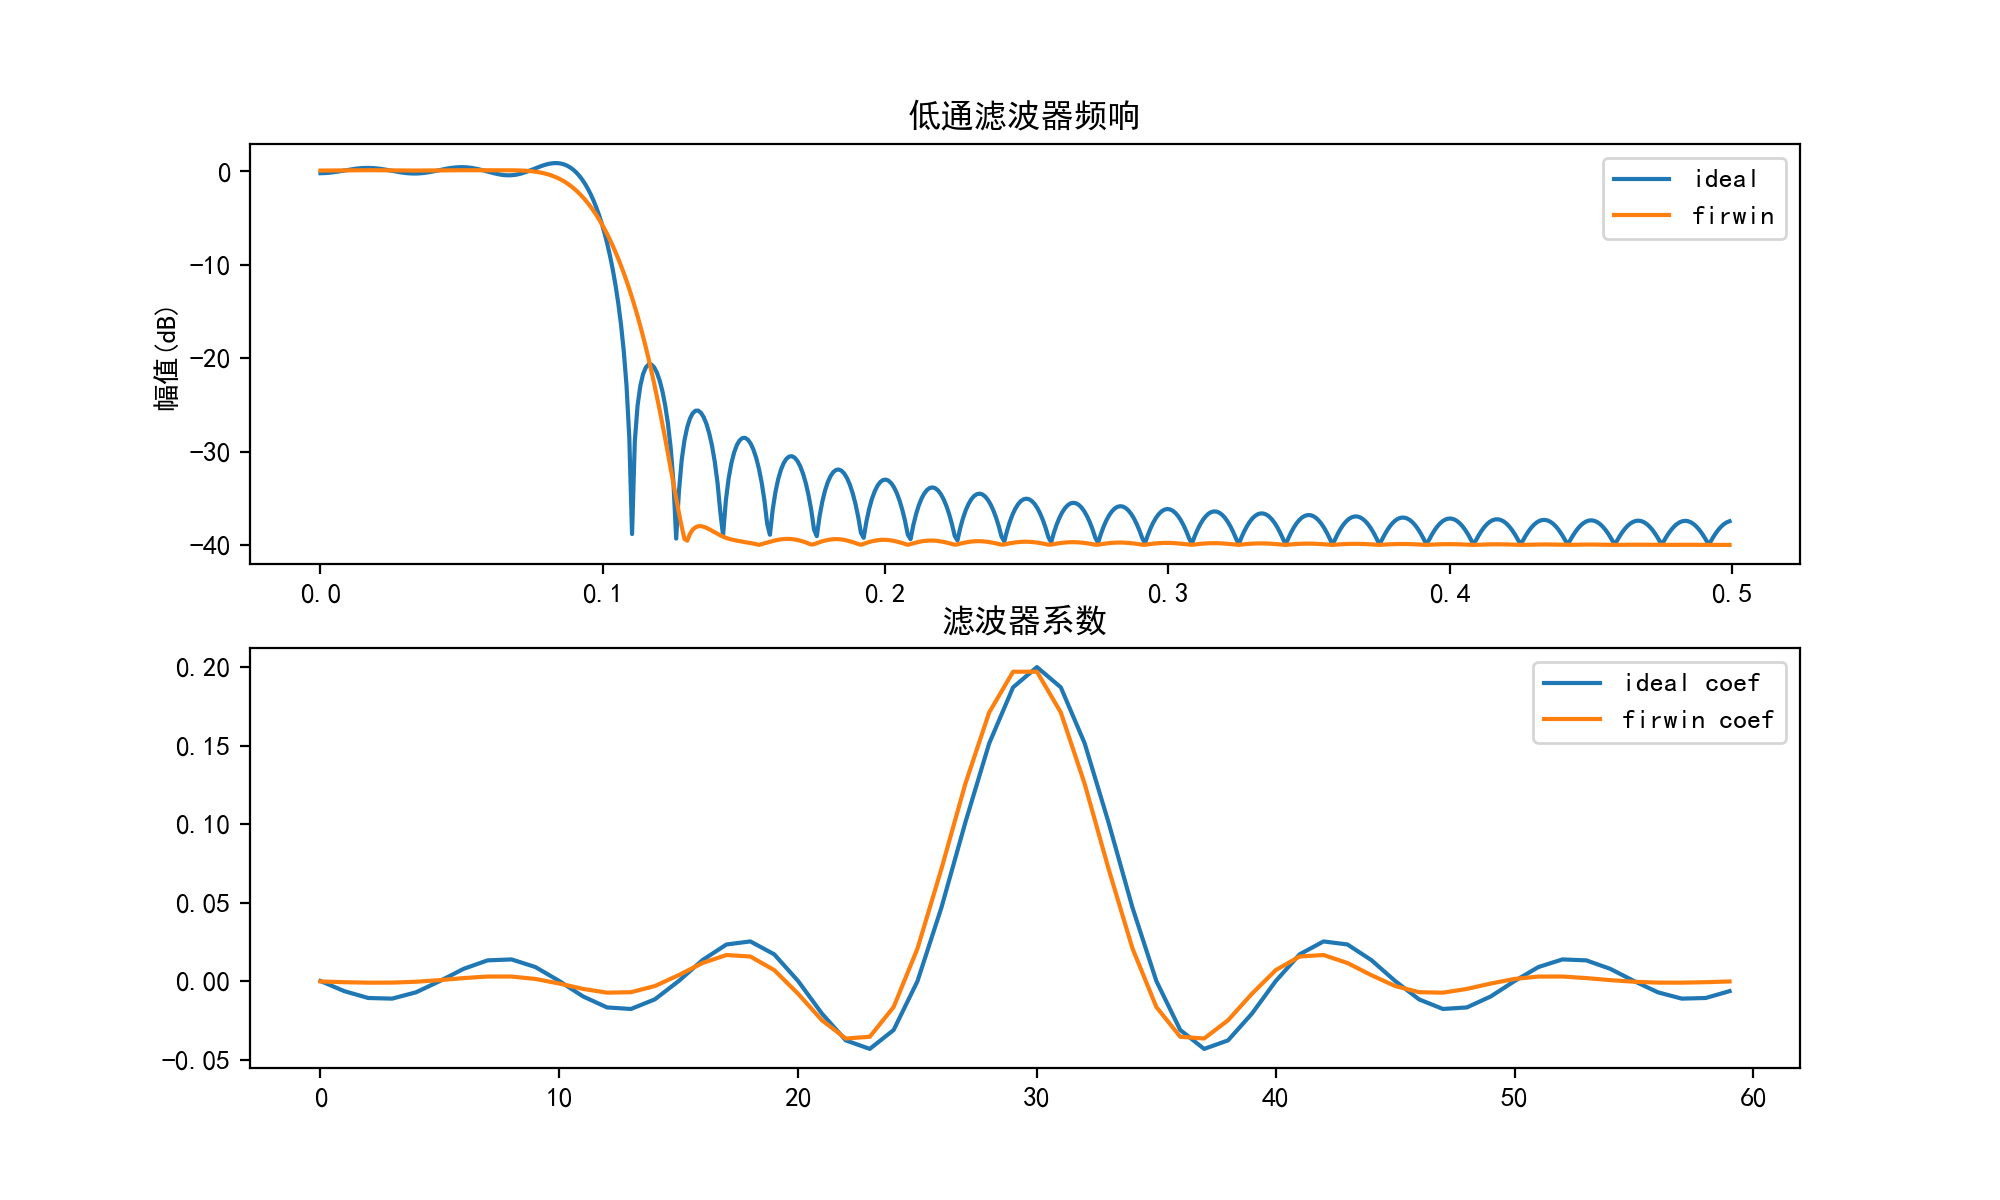

In [35]:
def lowpass_filter(n, fc):
    return 2 * fc * np.sinc(2 * fc * np.arange(-n, n, 1.0))

# 截止频率 0.1 * fs
b1 = lowpass_filter(30, 0.1)
b2 = signal.firwin(len(b1), 0.2)

# 频率响应
w1, h1 = signal.freqz(b1)
w2, h2 = signal.freqz(b2)

# 画图
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(w1/2/np.pi, 20*np.log10(np.abs(h1)+0.01), label = 'ideal')
plt.plot(w2/2/np.pi, 20*np.log10(np.abs(h2)+0.01), label = 'firwin')
plt.legend()
plt.ylabel(u"幅值(dB)")
plt.title('低通滤波器频响')

plt.subplot(2,1,2)
plt.title('滤波器系数')
plt.plot(b1, label='ideal coef')
plt.plot(b2, label='firwin coef')
plt.legend()
plt.show()

In [6]:
len(w)
b

array([ 5.71863221e-17,  1.09762030e-02, -1.94908592e-17, -1.17892550e-02,
       -2.40039057e-17,  1.27323954e-02, -1.94908592e-17, -1.38395603e-02,
        7.08937631e-17,  1.51576136e-02, -1.94908592e-17, -1.67531519e-02,
        1.94908592e-17,  1.87241110e-02, -1.94908592e-17, -2.12206591e-02,
        1.94908592e-17,  2.44853759e-02, -1.94908592e-17, -2.89372624e-02,
        1.94908592e-17,  3.53677651e-02, -1.94908592e-17, -4.54728409e-02,
        1.94908592e-17,  6.36619772e-02, -1.94908592e-17, -1.06103295e-01,
        1.94908592e-17,  3.18309886e-01,  5.00000000e-01,  3.18309886e-01,
        1.94908592e-17, -1.06103295e-01, -1.94908592e-17,  6.36619772e-02,
        1.94908592e-17, -4.54728409e-02, -1.94908592e-17,  3.53677651e-02,
        1.94908592e-17, -2.89372624e-02, -1.94908592e-17,  2.44853759e-02,
        1.94908592e-17, -2.12206591e-02, -1.94908592e-17,  1.87241110e-02,
        1.94908592e-17, -1.67531519e-02, -1.94908592e-17,  1.51576136e-02,
        7.08937631e-17, -

# 参考

* [数字信号系统](https://www.kancloud.cn/wizardforcel/hyry-studio-scipy/129096)